In [13]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sp-500-stocks:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2515222%2F4268503%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240522%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240522T135121Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D947adcbe845ad893d7bdb6be10108acd325dd43b6a8e0a958e915063130575cad0463c928ddb01a14073bc3ca2f3b224deefda20cf5f51a64fe2e7445db52a0e45b118e298b93efd9773af73df65c0c7ac8f22fa856dded34e10a3c229216c7d66f9d7989ae9b93e10d56b7d9d19a644f7b623c7723ddc67d9e2479a1e6073c006e215fd655a9286cb45c5db5705b5709931db62b8f1d076bc51cf242485dda767d386604c3b3e1ae12b1ea73ec6ed0d3ba9d40b51fc57f63488a64cfd69fc339f126ef789492b2d2158a97feac9e92c716753e6d40ab0fdc9dbac9bcd6cbec0deacbbe62b4fbf82bd5858ba1b6dfa21d24a54f87940162498b22f803ac33f60'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 11208 bytes downloaded
Downloaded and uncompressed: sp-500-stocks
Data source import complete.


# **Постановка задачи**

Цель: по одному или нескольким параметрам быстро сориентироваться и продать/купить индексный фонд (привязан к индексу S&P 500).

Гипотеза: в зависимости от объема торгов или цены открытия/закрытия предыдущего дня можно сделать вывод о необходимости покупки/продажи фонда.

# **Загрузка данных**

In [14]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sp-500-stocks/sp 500.csv


In [15]:
df = pd.read_csv('/kaggle/input/sp-500-stocks/sp 500.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Sep 01, 2022","3,936.73","4,119.28","3,610.40","3,640.47","3,640.47","88,667,050,000"
1,"Aug 01, 2022","4,112.38","4,325.28","3,954.53","3,955.00","3,955.00","78,088,520,000"
2,"Jul 01, 2022","3,781.00","4,140.15","3,721.56","4,130.29","4,130.29","68,021,140,000"
3,"Jun 01, 2022","4,149.78","4,177.51","3,636.87","3,785.38","3,785.38","86,799,060,000"
4,"May 01, 2022","4,130.61","4,307.66","3,810.32","4,132.15","4,132.15","89,128,130,000"


# **Обработка данных**

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       453 non-null    object
 1   Open       453 non-null    object
 2   High       453 non-null    object
 3   Low        453 non-null    object
 4   Close      453 non-null    object
 5   Adj Close  453 non-null    object
 6   Volume     453 non-null    object
dtypes: object(7)
memory usage: 24.9+ KB


In [17]:
# Приведём типы данных
df['Date'] = pd.to_datetime(df['Date'])
columns = df.columns
for i in range(1, len(columns)):
    df[columns[i]] = df[columns[i]].str.replace(',', '')
df[columns[1:]] = df[columns[1:]].astype(float)
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-09-01,3936.73,4119.28,3610.40,3640.47,3640.47,8.866705e+10
1,2022-08-01,4112.38,4325.28,3954.53,3955.00,3955.00,7.808852e+10
2,2022-07-01,3781.00,4140.15,3721.56,4130.29,4130.29,6.802114e+10


In [18]:
# Теперь все типы данных должны быть на своих местах :) Проверим это
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       453 non-null    datetime64[ns]
 1   Open       453 non-null    float64       
 2   High       453 non-null    float64       
 3   Low        453 non-null    float64       
 4   Close      453 non-null    float64       
 5   Adj Close  453 non-null    float64       
 6   Volume     453 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 24.9 KB


In [20]:
df.describe().round(2)

,Date,Open,High,Low,Close,Adj Close,Volume
count,453,453.00,453.00,453.00,453.00,453.00,4.530000e+02
mean,2003-10-31 19:17:05.165562880,1318.24,1363.20,1271.57,1325.11,1325.11,4.340568e+10
min,1985-01-01 00:00:00,167.20,180.27,163.36,179.63,179.63,1.860160e+09
25%,1994-06-01 00:00:00,462.69,471.29,454.36,463.56,463.56,6.152870e+09
50%,2003-11-01 00:00:00,1144.94,1190.58,1106.42,1147.39,1147.39,2.998151e+10
75%,2013-04-01 00:00:00,1569.18,1597.57,1536.03,1597.57,1597.57,7.584851e+10
max,2022-09-01 00:00:00,4778.14,4818.62,4560.00,4766.18,4766.18,1.618436e+11
std,NaN,1000.22,1035.10,962.09,1002.91,1002.91,3.769421e+10


Ничего необычного в описательной статистике не наблюдается

In [25]:
df.duplicated().value_counts()

False    453
Name: count, dtype: int64

Дубликатов в датасете нет

# **Анализ данных**

In [32]:
import plotly.graph_objects as go


fig = go.Figure(data=[go.Candlestick(x=df['Date'], open=df['Open'],
                               high=df['High'],low=df['Low'],
                               close=df['Close'])])
fig.add_hline(y=3640, line_width=2, line_color="black")
fig.show()

На свечном графике я провёл горизонтальную чёрную линию. С ней лучше видно, что за последние несколько месяцев цена S&P 500 не опускалась примерно ниже этой линии и постоянно отскакивала от неё. К тому же, около января 2021 года и немного ранее происходили отскоки цены от этой линии. Сначала в августе 2020го цена поднялась до этого уровня, отскочила, затем закрылась в ноябре на этом уровне, пробила его, в январе 2021го снова опустилась до него, затем отскочила и пошла дальше вверх. Это сигнализирует о том, что уровень какой-то важный. Также учитывая, что за всё данное время цена в среднем росла, то есть тренд на повышение цены, то логично предположить, что от этого важного уровня цена отскочит.

Таким образом индексный фонд нужно ***покупать***

# **Матрица корреляции**

<Axes: >

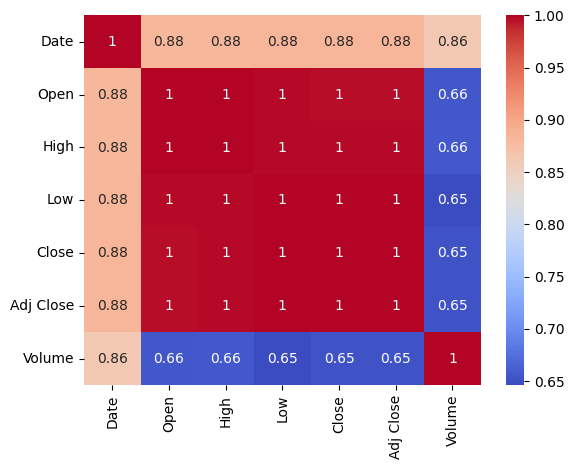

In [28]:
import seaborn as sns
sns.heatmap(data=df.corr(), annot=True, cmap='coolwarm')

Из матрицы корреляций видно, что цены открытия, закрытия, максимальные и минимальные имеют очень сильную линейную зависимость, что вообще говоря не удивительно для свечного графика. Учитывая, что корреляция цен свечей с датой значительно больше, чем с объёмами торгов, то можно считать что объём торгов слабо влияет на цену индекса S&P 500. Поэтому при построении прогноза объём торгов учитывать не будем